# ATIVIDADE 1 - EMBEDDINGS
## Para hoje/amanhã

1. Escolham duas playlists do youtube com temas distintos ou realizem scrapping de conteúdos distintos
2. Tomem os embeddings dos vídeos/conteúdos
3. Comparem os embeddings de cada segmento em um gráfico bidimensional.
4. Treinem um classificador em cima dos embeddings dos chunks.
5. Analisem quais chunks o modelo treinado mais teve dificuldade em classificar.
6. **(EXTRA/DESAFIO)**: Busquem o 'tema' central dos conteúdos (ou seja, identifique os centróides dos embeddings); Selecione um dos temas centrais e busque os chunks/embeddings que estão mais relacionados a este tema central (vocês podem utilizar a famosa `similaridade cosseno` from scratch mesmo para buscar os embeddings mais próximos --- semanticamente --- e consequentemente os chunks associados)

In [18]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytube import Playlist 
from youtube_transcript_api import YouTubeTranscriptApi

from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

from dotenv import load_dotenv
import os

from tqdm import tqdm

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [19]:
# pegando as playlists
URL_PLAYLIST1 = "https://www.youtube.com/watch?v=ENK56-CMuiU&list=PLL3n-FDy7MHdGDU-quxmZyoCgDepc0RGT"
URL_PLAYLIST2 = "https://www.youtube.com/watch?v=P6ivcF1tBm4&list=PLbqt4HPEAdEN1YlgS-QS_JB8KYzcZI7xj"

playlist1 = Playlist(URL_PLAYLIST1)
playlist2 = Playlist(URL_PLAYLIST2)

playlist1_urls = set(playlist1.video_urls)
playlist2_urls = set(playlist2.video_urls)  

urls = playlist1_urls | playlist2_urls

urls

{'https://www.youtube.com/watch?v=--Fvzgj57_U',
 'https://www.youtube.com/watch?v=-S3NrX62FbU',
 'https://www.youtube.com/watch?v=19nSWNXcn6w',
 'https://www.youtube.com/watch?v=1x-H0iDV5do',
 'https://www.youtube.com/watch?v=2VrUBUPviOI',
 'https://www.youtube.com/watch?v=30YrwqX9sOg',
 'https://www.youtube.com/watch?v=3Knyzo3ugnU',
 'https://www.youtube.com/watch?v=46U-YAGI1ig',
 'https://www.youtube.com/watch?v=4sWLP75hkq8',
 'https://www.youtube.com/watch?v=5mSh6ZfToVs',
 'https://www.youtube.com/watch?v=62dGUheoRMc',
 'https://www.youtube.com/watch?v=6A58U9DzBLY',
 'https://www.youtube.com/watch?v=704V1FAGIR8',
 'https://www.youtube.com/watch?v=7xggjnvT_Ok',
 'https://www.youtube.com/watch?v=8OrncshjOg0',
 'https://www.youtube.com/watch?v=8td8flnarqA',
 'https://www.youtube.com/watch?v=9_-DasSSjC8',
 'https://www.youtube.com/watch?v=9oSvtHujMyk',
 'https://www.youtube.com/watch?v=A8c6u_T7f-0',
 'https://www.youtube.com/watch?v=AKKh6k0sVZI',
 'https://www.youtube.com/watch?v=BesQwD

In [20]:
textos_playlist1 = dict()
textos_playlist2 = dict()

# scrapping 
for url in tqdm(urls):
    video_id = url.split("v=")[1].split("&")[0]
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
        texts = [entry['text'] for entry in transcript]

        if url in playlist1_urls:
            textos_playlist1[url] = texts

        elif url in playlist2_urls:
            textos_playlist2[url] = texts

    except Exception as e:
        print(f"Erro ao pegar transcript do vídeo {url}: {e}")

 45%|████▌     | 56/124 [01:32<01:37,  1.43s/it]

Erro ao pegar transcript do vídeo https://www.youtube.com/watch?v=BesQwDucZwQ: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=BesQwDucZwQ! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


 81%|████████  | 100/124 [02:12<00:25,  1.07s/it]

Erro ao pegar transcript do vídeo https://www.youtube.com/watch?v=VlBmZhzNc6k: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=VlBmZhzNc6k! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


100%|██████████| 124/124 [01:51<00:00,  1.11it/s]


In [21]:
if textos_playlist1:
    first_url = list(textos_playlist1.keys())[0]
    print(f"num de entradas na transcrição do primeiro vídeo: {len(textos_playlist1[first_url])}")

f5 = textos_playlist1[first_url][:5]

# print primeiras 5 transcripts video 1 
f5

num de entradas na transcrição do primeiro vídeo: 385


["hey how's it going guys jack and matt",
 'here with the toaster bros and today',
 "we're excited to bring you a $1,500",
 'streaming and gaming setup this setup is',
 'going to be really awesome']

In [22]:
# save
with open("playlist1_texts.txt", "w", encoding="utf-8") as file1:
    for url, texts in textos_playlist1.items():
        concat = " ".join(texts)  # concatena todos os textos do vídeo em uma string
        file1.write(concat + "\n\n")

with open("playlist2_texts.txt", "w", encoding="utf-8") as file2:
    for url, texts in textos_playlist2.items():
        concat = " ".join(texts)  
        file2.write(concat + "\n\n")

print(f"textos da playlist 1 salvos em 'playlist1_texts.txt'.")
print(f"textos da playlist 2 salvos em 'playlist2_texts.txt'.")

textos da playlist 1 salvos em 'playlist1_texts.txt'.
textos da playlist 2 salvos em 'playlist2_texts.txt'.


#### Embeddando os textos; (OpenAI API)

In [23]:
# carregando os textos
with open("playlist1_texts.txt", "r", encoding="utf-8") as file1:
    text1 = file1.read()

with open("playlist2_texts.txt", "r", encoding="utf-8") as file2:
    text2 = file2.read()

In [24]:
# splitter 
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000, # 1000 caracteres
    chunk_overlap= 500, # overlap de 250 caracteres
    length_function=len, 
    is_separator_regex=False,
)

# chunks
chunks1 = text_splitter.split_text(text1)
chunks2 = text_splitter.split_text(text2)

print(len(chunks1), len(chunks2))

1011 426


In [25]:
# embeddings
embedding_size = 1536 # tamanho do embedding
embedding_model = "text-embedding-3-small"
openai = OpenAIEmbeddings(model=embedding_model, dimensions=embedding_size, api_key=OPENAI_API_KEY)

# embeddings playlist 1
embeddings1 = np.array(openai.embed_documents(chunks1))

# embeddings playlist 2
embeddings2 = np.array(openai.embed_documents(chunks2))

# concatenando os embeddings
all_embeddings = np.concatenate([embeddings1, embeddings2], axis=0)

print(embeddings1.shape)
print(embeddings2.shape)
print(all_embeddings.shape)

(1011, 1536)
(426, 1536)
(1437, 1536)


#### Viz; (t-SNE)

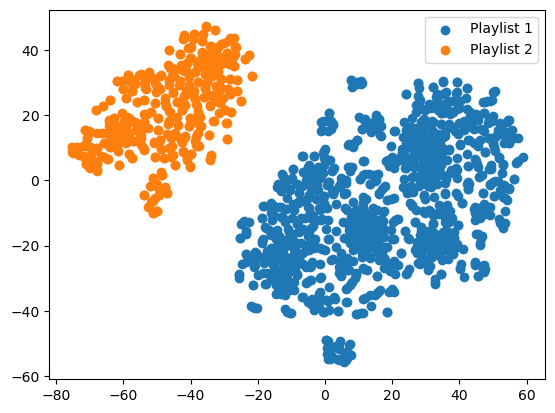

In [148]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(all_embeddings)

# plot
plt.scatter(tsne_embeddings[:len(embeddings1), 0], tsne_embeddings[:len(embeddings1), 1], label="Playlist 1")
plt.scatter(tsne_embeddings[len(embeddings1):, 0], tsne_embeddings[len(embeddings1):, 1], label="Playlist 2")
plt.legend()
plt.show()

#### Modeling;

In [149]:
from sklearn.model_selection import train_test_split

y_hat = np.array([0] * len(embeddings1) + [1] * len(embeddings2)) # labels

X_train, X_test, y_train, y_test = train_test_split(all_embeddings, y_hat, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1149, 1536), (288, 1536))

In [150]:
import torch
from torch import nn
import torch.optim as optim

class CLF(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLF, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input
        self.relu = nn.LeakyReLU() # activation
        self.dropout = nn.Dropout(p=0.5) # dropout 
        self.fc2 = nn.Linear(hidden_size, output_size) # output
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x    

In [151]:
# hiperparâmetros
input_size = 1536  
hidden_size = 256
num_classes = 2
learning_rate = 0.001
num_epochs = 20

model = CLF(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
from sklearn.metrics import classification_report

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_losses = []

# training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward pass
    loss.backward()
    optimizer.step()

    # losses
    train_losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# plot acurácia
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

Epoch [1/20], Loss: 0.6940
Epoch [2/20], Loss: 0.6441
Epoch [3/20], Loss: 0.5967
Epoch [4/20], Loss: 0.5493
Epoch [5/20], Loss: 0.4989
Epoch [6/20], Loss: 0.4495
Epoch [7/20], Loss: 0.4020
Epoch [8/20], Loss: 0.3570
Epoch [9/20], Loss: 0.3127
Epoch [10/20], Loss: 0.2723
Epoch [11/20], Loss: 0.2353
Epoch [12/20], Loss: 0.2039
Epoch [13/20], Loss: 0.1720
Epoch [14/20], Loss: 0.1466
Epoch [15/20], Loss: 0.1240
Epoch [16/20], Loss: 0.1034
Epoch [17/20], Loss: 0.0870
Epoch [18/20], Loss: 0.0724
Epoch [19/20], Loss: 0.0611
Epoch [20/20], Loss: 0.0510


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       1.00      1.00      1.00        90

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



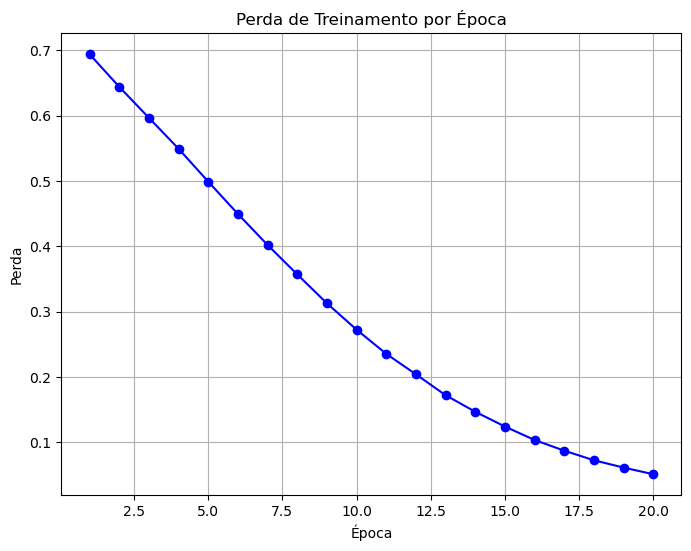

In [153]:
# report
print(classification_report(y_test, predicted))

# loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o", linestyle="-", color="b")
plt.title("Perda de Treinamento por Época")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.grid(True)
plt.show()

#### Análise Entropia; 


In [154]:
def shannon_entropy(p):
    return -np.sum(p * np.log2(p + 1e-9)) 

# converte os embeddings para tensor PyTorch
all_embeddings_tensor = torch.tensor(all_embeddings, dtype=torch.float32)

# passa os embeddings pelo modelo
outputs = model(all_embeddings_tensor) 

# calcular a softmax pois nao foi calculada no modelo
softmax = torch.nn.Softmax(dim=1)
all_outputs = softmax(outputs)

# calcula a entropia 
all_outputs_np = all_outputs.detach().numpy()  
entropy = np.array([shannon_entropy(x) for x in all_outputs_np])

# combina os chunks 
all_chunks = np.array(chunks1 + chunks2)

# labels preditos
_, y_hat = torch.max(all_outputs, dim=1)  # pega o índice da classe com maior probabilidade
y_hat_np = y_hat.cpu().numpy() 

In [155]:
# df com os resultados
df = pd.DataFrame({
    "entropy": entropy,
    "text": all_chunks,
    "label": y_hat_np
})

# ord por entropia e printar df
df = df.sort_values(by="entropy", ascending=False)

df

,entropy,text,label
1412,0.997273,so I bought them a set of kitchen knives so wh...,1
1409,0.940106,us plenty of Honey by the end of this summer t...,1
1411,0.938660,now though I've got to start packing up things...,1
1253,0.938367,forest and look for mushrooms and berries ther...,1
1297,0.893080,show you the whole process in the kitchen in a...,1
...,...,...,...
701,0.093162,you could have got ddr5 but you would have had...,0
419,0.092425,eight ninety percent render scale um 1063 gig ...,0
949,0.091041,for that Oh God Oh dude he didn't see a common...,0
594,0.088765,computer keyboard and mouse and typically a mo...,0


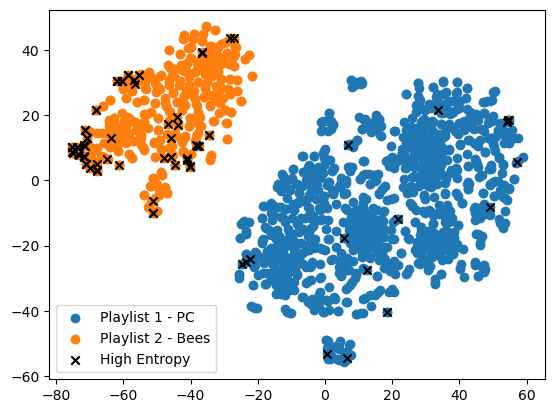

In [156]:
df['high_entropy'] = df['entropy'] > 0.4

plt.scatter(tsne_embeddings[:len(embeddings1), 0], tsne_embeddings[:len(embeddings1), 1], label="Playlist 1 - PC")
plt.scatter(tsne_embeddings[len(embeddings1):, 0], tsne_embeddings[len(embeddings1):, 1], label="Playlist 2 - Bees")

high_entropy_indices = df[df['high_entropy']].index
plt.scatter(tsne_embeddings[high_entropy_indices, 0], tsne_embeddings[high_entropy_indices, 1],
            label="High Entropy", color="black", marker="x")

plt.legend()
plt.show()

Os resultados foram piores para a playlist2 devido à quantidade de dados disponível para treino da MLP

#### DESAFIO;


In [157]:
# calcula os centróides para cada playlist
centroid_playlist1 = np.mean(embeddings1, axis=0)  
centroid_playlist2 = np.mean(embeddings2, axis=0)  

print(centroid_playlist1[:5])
print(centroid_playlist2[:5])

[ 0.03340905  0.00588469 -0.03349129 -0.00771733  0.01351664]
[ 0.04906014  0.03781332 -0.00901319 -0.01507485 -0.01164934]


A similaridade de cosseno é dada por:

$$
\text{cosine\_similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

Mas vamos utilizar a função pronta do sklearn por conveniência

In [158]:
from sklearn.metrics.pairwise import cosine_similarity

# similaridade do centróide com os embeddings
similarity_playlist1 = cosine_similarity(embeddings1, [centroid_playlist1]).flatten()
similarity_playlist2 = cosine_similarity(embeddings2, [centroid_playlist2]).flatten()

print(similarity_playlist1[:5])
print(similarity_playlist2[:5])

[0.79400265 0.79212104 0.81506937 0.7433183  0.77233823]
[0.81913386 0.82475342 0.82146973 0.78890457 0.6710532 ]


In [159]:
top_n = 5  # número de chunks mais próximos dos centroides	
top_indices_playlist1 = similarity_playlist1.argsort()[-top_n:][::-1]
top_indices_playlist2 = similarity_playlist2.argsort()[-top_n:][::-1]

# exibe os chunks mais relacionados
print("chunks mais próximos do centróide da Playlist 1:")
for idx in top_indices_playlist1:
    print(f"similaridade: {similarity_playlist1[idx]:.4f} | Chunk: {df.loc[idx, 'text']}")

print("\nchunks mais próximos do centróide da Playlist 2:")
for idx in top_indices_playlist2:
    print(f"similaridade: {similarity_playlist2[idx]:.4f} | Chunk: {df.loc[len(embeddings1) + idx, 'text']}")


chunks mais próximos do centróide da Playlist 1:
similaridade: 0.8795 | Chunk: eight ninety percent render scale um 1063 gig is limited in games like Warzone that are requiring more vrams so um yeah and uh super high-end games you're gonna have to run low settings 1080p with this PC but it's still technically playable and for 450 dollars I mean you're pretty happy with that you can spend a little bit more money to give some like a 1070 which will run this significantly better because of eight gigs of vram but again you are spending like probably 30 to 40 more dollars oh I can't go into that window which window am I oh God I'm just slowly falling hello I don't know what just happened there it looked good but it didn't really uh deliver if you know what I mean there's a lot going on here guys I don't like this game please don't kill me right away thank you [Music] push me damn it into the smoke I go into the thick of it threw a grenade at me that wow that was that was disrespectful Hambu

In [164]:
# add similaridade ao df
df["similarity_playlist1"] = np.concatenate([similarity_playlist1, [0] * len(embeddings2)])
df["similarity_playlist2"] = np.concatenate([[0] * len(embeddings1), similarity_playlist2])

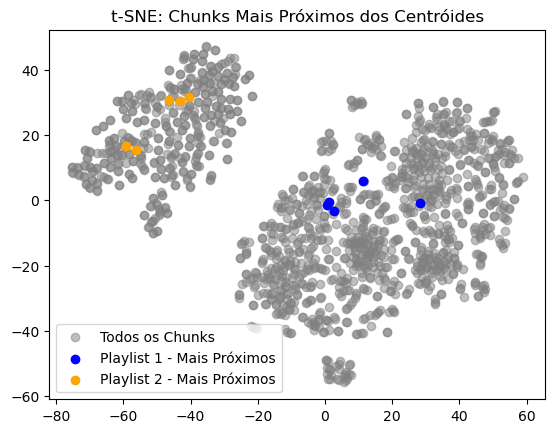

In [165]:
# plot centroides no tsne
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c="gray", alpha=0.5, label="Todos os Chunks")

# plota os pontos mais próximos dos centróides
plt.scatter(tsne_embeddings[top_indices_playlist1, 0], tsne_embeddings[top_indices_playlist1, 1],
            c="blue", label="Playlist 1 - Mais Próximos", marker="o")
plt.scatter(tsne_embeddings[len(embeddings1) + top_indices_playlist2, 0],
            tsne_embeddings[len(embeddings1) + top_indices_playlist2, 1],
            c="orange", label="Playlist 2 - Mais Próximos", marker="o")

plt.title("t-SNE: Chunks Mais Próximos dos Centróides")
plt.legend()
plt.show()

Chunks com alta similaridade são mais alinhados com o "tema central" da playlist e podem ser usados como exemplos representativos do conteúdo.

- Para a Playlist 1 (PC), o centróide reflete o tema principal relacionado à tecnologia, periféricos, e computadores.
- Para a Playlist 2 (Abelhas), o centróide reflete o tema principal relacionado à apicultura, cuidados com colmeias e produção de mel.